This file is a modification on GP_sklearn. We want to let the model choose the best hyperparameter on itself

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import gaussian_process
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ExpSineSquared,Matern,ConstantKernel
from sklearn.metrics import mean_squared_error
import random

# 1. Data Processing

In [26]:
#read the data and create data frame
df = pd.read_csv('heart_rate_data.csv')
df['time'] = np.linspace(0, 900, len(df))
df.columns = ['Y','time']
df

,Y,time
0,84.2697,0.000000
1,84.0619,0.500556
2,85.6542,1.001112
3,87.2093,1.501669
4,87.1246,2.002225
...,...,...
1794,103.7900,897.997775
1795,101.6230,898.498331
1796,99.5679,898.998888
1797,99.1835,899.499444


In [27]:
#To make better predictions, we break the data set into 3 parts. We use the head and tail as the training set and the middle part as the testing set
train_size = 100 #at the head
test_size = 100 #in the middle
train_size2 = 100 #at the tail
split = train_size + test_size + train_size2

#get training set
train = df[0:train_size].append(df[train_size + test_size:split]) 
X_train = np.array(train['time']).reshape(-1, 1)
Y_train = np.array(train['Y']).reshape(-1, 1)

#get testing set
test = df[train_size:train_size+test_size]
X_test = np.array(test['time']).reshape(-1, 1)
Y_test = np.array(test['Y']).reshape(-1, 1)

# Below df are only used for poltting the data
# we add nan in between 2 parts of training data to avoid the straight line between twp training set in later plotting
df_train_two_side = df.copy(deep=True)
df_train_two_side['Y'][train_size:train_size+test_size] = np.nan
train_2_side = df_train_two_side[0:split]
X_train_with_nan = np.array(train_2_side['time']).reshape(-1, 1) 
Y_train_with_nan = np.array(train_2_side['Y']).reshape(-1, 1)    

#arange all the data
X_all = np.array(df['time'])[:train_size + test_size + train_size2]

/var/folders/ts/xc6_h0kd5nv7gws_x4n04jwr0000gn/T/ipykernel_30071/3706113157.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = df[0:train_size].append(df[train_size + test_size:split])


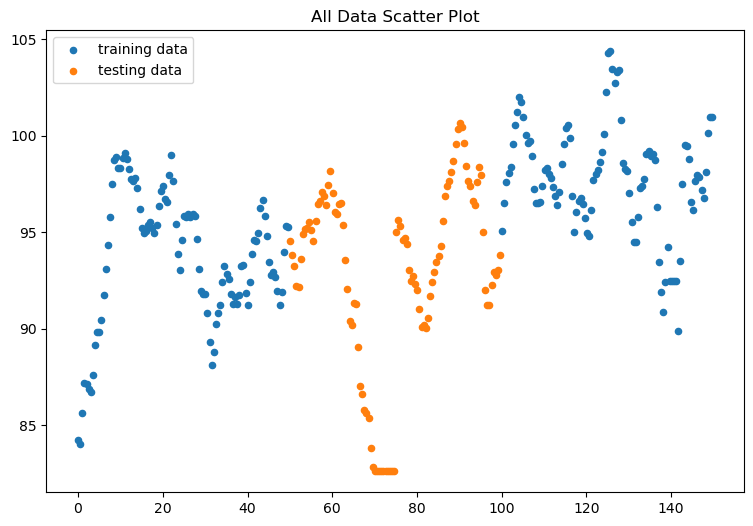

In [28]:
#plot all the data
plt.figure(figsize=(9, 6))
plt.title('All Data Scatter Plot')
plt.scatter(X_train_with_nan, Y_train_with_nan, label = 'training data', s=20)
plt.scatter(X_test,Y_test, label = 'testing data', s=20)
plt.legend()

# 2. Design Kernel and GP model

## 2.1 Test if different initial paramters for kernel yield to same results

### 2.1.1 Train 2 models with different initial kernel hyper parameters and compare their final parameters

In [29]:
kernel_1 = ConstantKernel(3) * ExpSineSquared() + RBF()+ WhiteKernel(0.6)
gp_1 = gaussian_process.GaussianProcessRegressor(kernel=kernel_1, )
# Fit to data using MLE
gp_1.fit(X_train, Y_train)

GaussianProcessRegressor(kernel=1.73**2 * ExpSineSquared(length_scale=1, periodicity=1) + RBF(length_scale=1) + WhiteKernel(noise_level=0.6))

In [30]:
kernel_2 = ConstantKernel(2.5) * ExpSineSquared() + RBF()+ WhiteKernel(1.1)
gp_2 = gaussian_process.GaussianProcessRegressor(kernel=kernel_2, random_state = random.seed(15))
# Fit to data using MLE
gp_2.fit(X_train, Y_train)

GaussianProcessRegressor(kernel=1.58**2 * ExpSineSquared(length_scale=1, periodicity=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1.1))

In [31]:
kernel_3 = ConstantKernel(2.5) * ExpSineSquared() + RBF()+ WhiteKernel(4)
gp_3 = gaussian_process.GaussianProcessRegressor(kernel=kernel_3, random_state = random.seed(10))
# Fit to data using MLE
gp_3.fit(X_train, Y_train)

GaussianProcessRegressor(kernel=1.58**2 * ExpSineSquared(length_scale=1, periodicity=1) + RBF(length_scale=1) + WhiteKernel(noise_level=4))

In [32]:
# print the kernel with fitted parameters
print(gp_1.kernel_), print(gp_2.kernel_), print(gp_3.kernel_)

94.4**2 * ExpSineSquared(length_scale=58.1, periodicity=27.5) + RBF(length_scale=2.25) + WhiteKernel(noise_level=1.5)
59.5**2 * ExpSineSquared(length_scale=2.84, periodicity=34.6) + RBF(length_scale=2.22) + WhiteKernel(noise_level=1.38)
60.1**2 * ExpSineSquared(length_scale=2.82, periodicity=23.1) + RBF(length_scale=2.73) + WhiteKernel(noise_level=1.4)


(None, None, None)

As we can see, they yield to same parameters

Text(0.5, 1.0, 'kernel post-fitting')

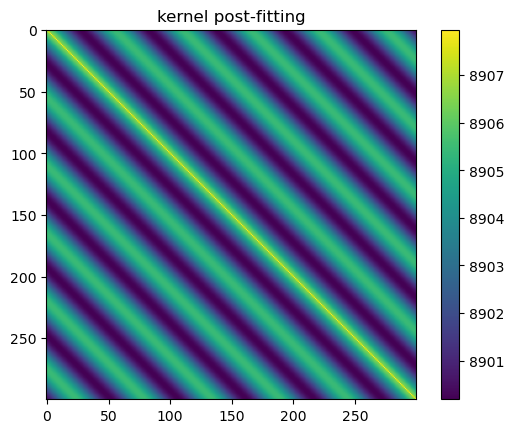

In [33]:
# plot the kernel
plt.figure()
plt.imshow(gp_1.kernel_(np.array([X_all]).T))
plt.colorbar()
plt.title('kernel post-fitting')

Text(0.5, 1.0, 'kernel post-fitting')

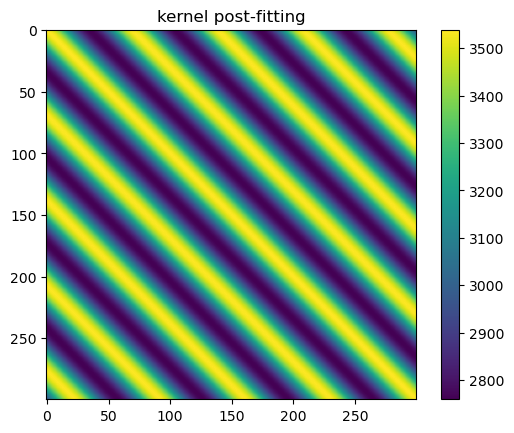

In [34]:
plt.figure()
plt.imshow(gp_2.kernel_(np.array([X_all]).T))
plt.colorbar()
plt.title('kernel post-fitting')

### 2.1.2 Futher validation by compare their Predictions

In [35]:
# Make the prediction on the meshed x-axis (ask for MSE as well)
Y_pred_all_1, sigma_all_1 = gp_1.predict(X_all.reshape(-1, 1), return_std=True)
Y_pred_test_1, sigma_test_1 = gp_1.predict(X_test, return_std=True)
Y_pred_train_1, sigma_train_1 = gp_1.predict(X_train, return_std=True)

In [36]:
Y_pred_all_2, sigma_all_2 = gp_2.predict(X_all.reshape(-1, 1), return_std=True)
Y_pred_test_2, sigma_test_2 = gp_2.predict(X_test, return_std=True)
Y_pred_train_2, sigma_train_2 = gp_2.predict(X_train, return_std=True)

Design the Plot Function

In [37]:
def plot_gp(X, Y_pred, sigmas, samples=None):
    plt.figure(figsize = (10, 6))
    if samples is not None:
        plt.plot(X_all.reshape(-1, 1), samples)
    
    plt.scatter(X_train_with_nan, Y_train_with_nan, label = 'training data', s=20, c = 'tomato')
    plt.scatter(X_test,Y_test, label = 'testing data', s=20, c = 'orange')

    markers, caps, bars = plt.errorbar(X, Y_pred, yerr=sigmas, capsize=0, 
            ecolor=(0.85, 0.85, 0.85), fmt = "-", 
            label="pred mean")
    # loop through bars and caps and set the alpha value
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]

    plt.title('GP result Analysis')
    plt.xlabel('$time$')
    plt.legend()

Make the plot

ValueError: operands could not be broadcast together with shapes (300,1) (2,300) 

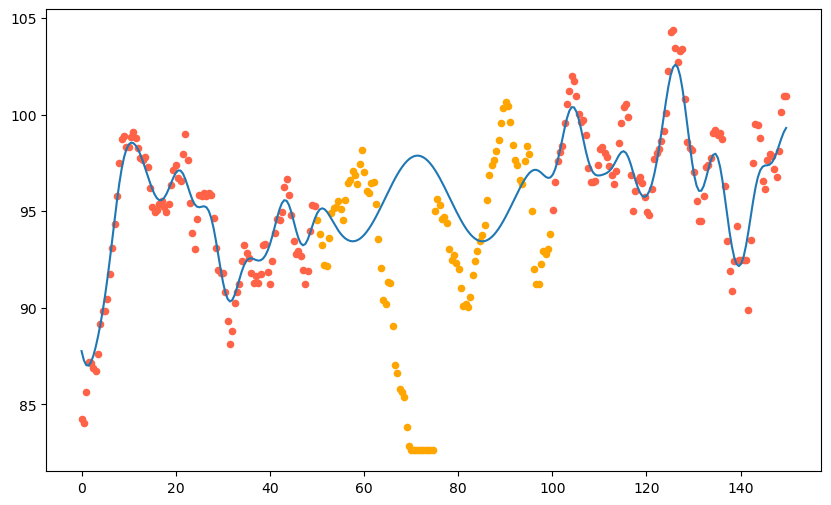

In [38]:
plot_gp(X_all, Y_pred_all_1, sigma_all_1, samples=None)

ValueError: operands could not be broadcast together with shapes (300,1) (2,300) 

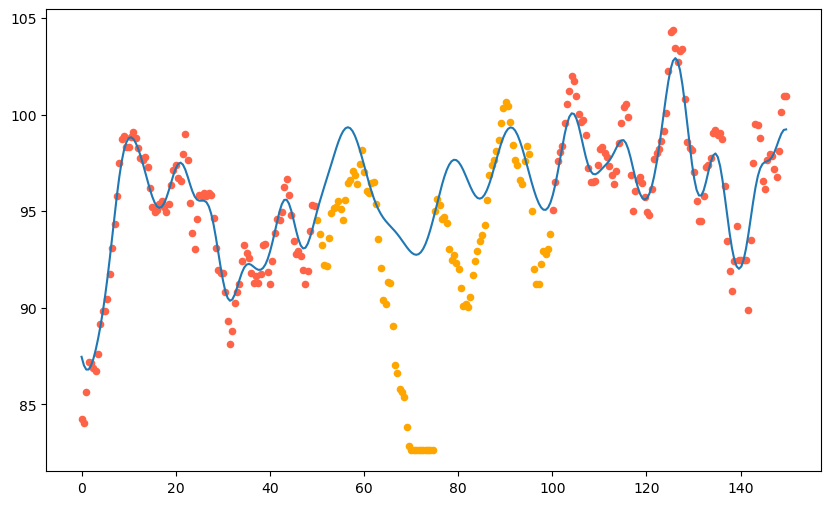

In [39]:
plot_gp(X_all, Y_pred_all_2, sigma_all_2, samples=None)